In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
import pandas as pd
from scipy.integrate import odeint

### Opening predator-prey dataset

In [5]:
df = pd.read_csv('predator-prey-data.csv', index_col=False)
df.head()


,Unnamed: 0,t,x,y
0,0,0.000000,4.781635,3.035257
1,1,0.202020,6.114005,2.189746
2,2,0.404040,6.238361,1.478907
3,3,0.606061,5.520524,0.989836
4,4,0.808081,4.582546,0.957827


[[ 0.          4.78163509  3.03525736]
 [ 0.2020202   6.11400461  2.18974589]
 [ 0.4040404   6.23836095  1.47890677]
 [ 0.60606061  5.52052405  0.98983604]
 [ 0.80808081  4.58254575  0.95782741]
 [ 1.01010101  3.69549338  0.8089764 ]
 [ 1.21212121  2.73241063  0.5550991 ]
 [ 1.41414141  1.93007859  0.48259774]
 [ 1.61616162  1.61129364  0.54557416]
 [ 1.81818182  1.25280509  0.7378781 ]
 [ 2.02020202  0.99647646  0.61912135]
 [ 2.22222222  0.83616635  0.71381421]
 [ 2.42424242  0.55796464  0.80913925]
 [ 2.62626263  0.42574735  0.90709674]
 [ 2.82828283  0.29284544  1.20019798]
 [ 3.03030303  0.42998578  1.15551425]
 [ 3.23232323  0.29047429  1.4620071 ]
 [ 3.43434343  0.23623108  1.7790317 ]
 [ 3.63636364  0.44737461  1.90884655]
 [ 3.83838384  0.34584789  2.18036662]
 [ 4.04040404  0.26683052  2.45451334]
 [ 4.24242424  0.52841771  2.87645734]
 [ 4.44444444  0.65807025  3.34293736]
 [ 4.64646465  0.99468762  3.64158993]
 [ 4.84848485  1.56856111  3.9487383 ]
 [ 5.05050505  2.55628162

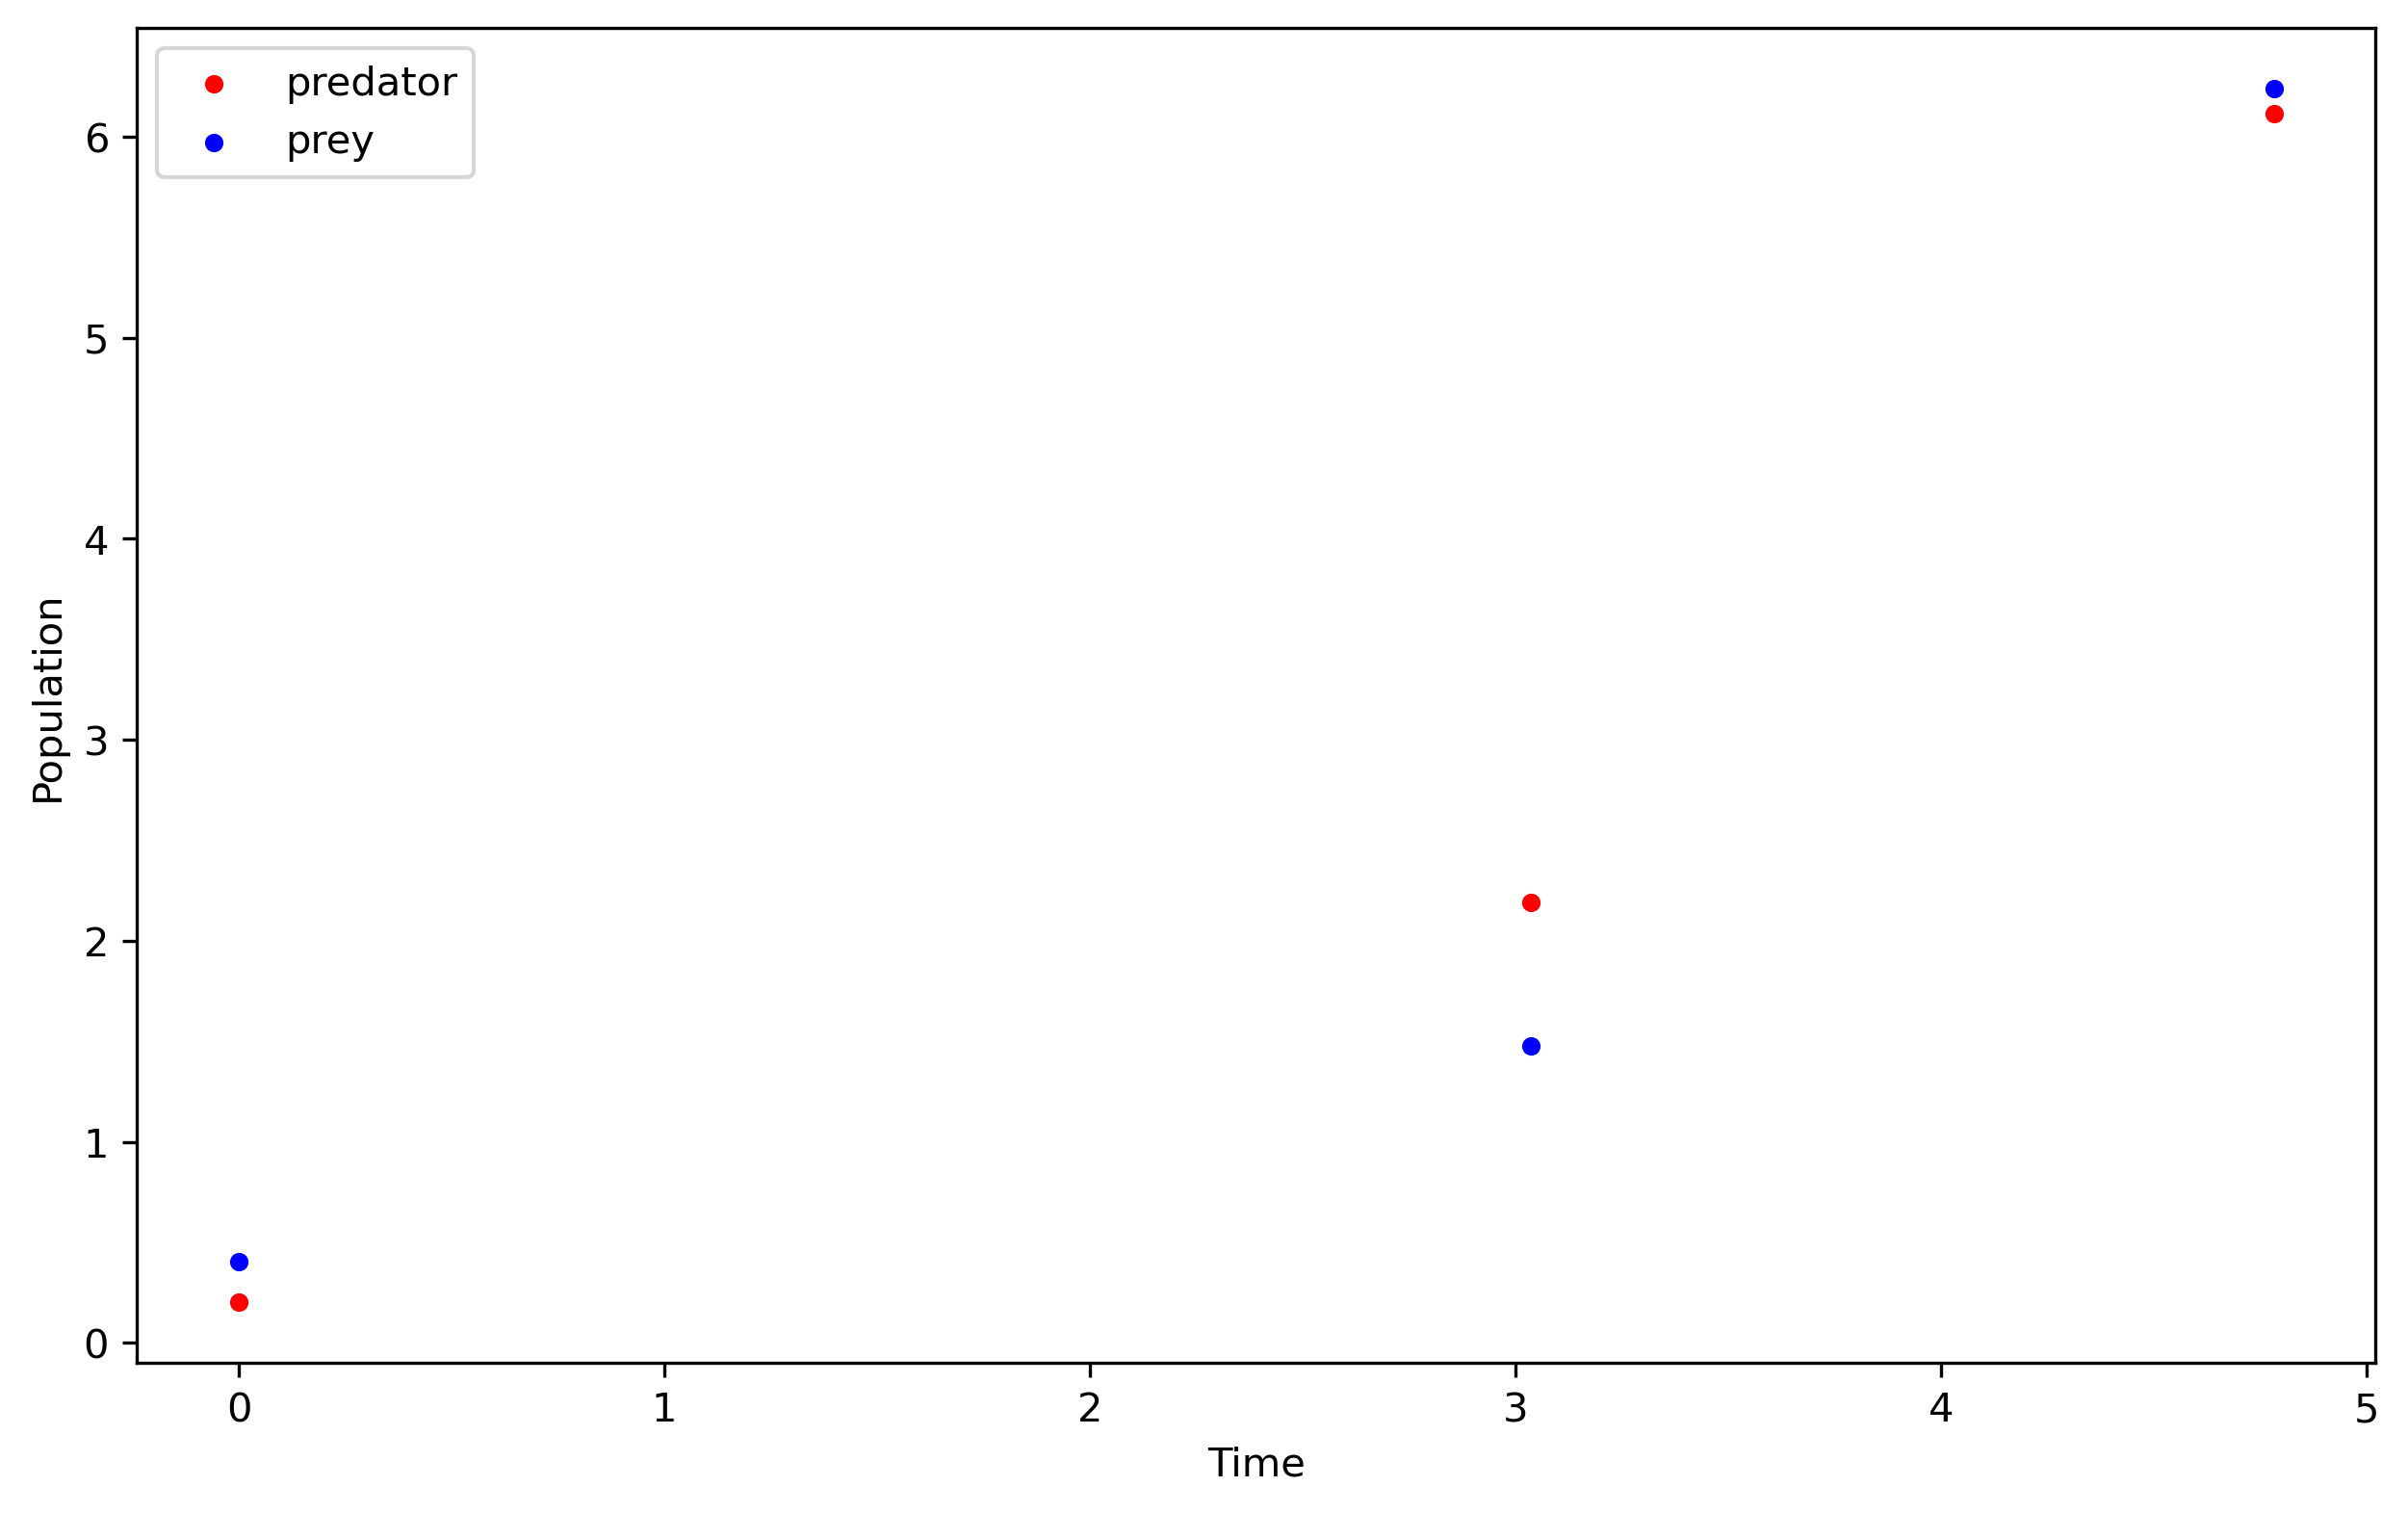

In [135]:
# Loading data into read-only numpy arrays
data = df[['t','x','y']].values
# data[1], data[2] = data[2].copy(), data[1].copy()
data.flags.writeable = False
print(data)

# Plotting
plt.figure(dpi =300, figsize=(10, 6))
point_width = 13
plt.scatter(data[0], data[1], label = 'predator', color = 'red', s =point_width)
plt.scatter(data[0], data[2], label = 'prey', color = 'blue', s=point_width)
plt.ylabel('Population')
plt.xlabel('Time')
plt.legend()

print(data[0])

### Objective functions

#### Defining volterra equations function

In [90]:
def predator_prey_odes(initial_conditions,time ,alpha, beta, delta, gamma):
    
    x = initial_conditions[0]  # initial predator population
    y = initial_conditions[1]  # initial prey population
    dxdt = (alpha * x) - (beta * x * y)  # Predator ODE
    dydt = (delta * x * y) - (gamma * y)  # Predator ODE
    return [dxdt, dydt]


In [91]:
#Function that will return the data for predator and prey for a given set of parameters
def predator_prey_integration(time,initial_conditions,parameters): 
    alpha,beta,delta,gamma = parameters
    #odeint is now used as part of this function which returns the # of infected in the model
    results = odeint(predator_prey_odes,initial_conditions, time, args=(alpha,beta,delta,gamma)) 
    predator_values,prey_values = results[:,0], results[:,1]
    return np.array([predator_values,prey_values])



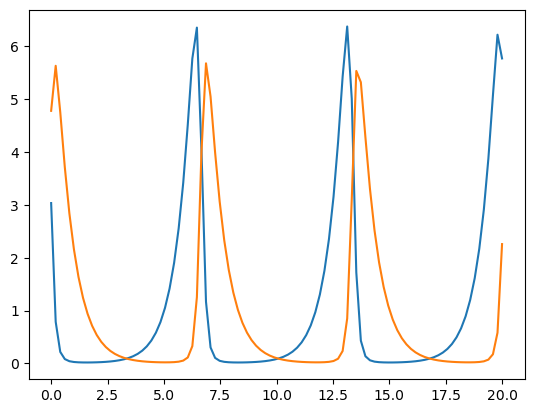

In [129]:
t, x ,y = data
initial_conditions = [x[0],y[0]]
alpha = 1.5
beta = 1.5
delta = 1.3
gamma = 1.4
parameters = [alpha, beta, delta, gamma]

# Using MSE
x = predator_prey_integration(t,initial_conditions,parameters)

# plt.scatter(x[0],x[1])
plt.plot(t, x[0])
plt.plot(t, x[1])

# plt.plot(t[0:9], x[0][0:9])
# plt.plot(t[0:9], x[1][0:9])
# plt.xlim(0,7.5)
# plt.xscale('log')

### Defining objective functions

In [20]:
def negative_log_likelihood(actual, predicted, variance=1.0):
    '''Log likelyhood function'''
    # Assuming a normal distribution for simplicity
    log_likelihoods1 =norm.logpdf(actual[0], loc=predicted[0], scale=np.sqrt(variance))
    log_likelihoods2 = norm.logpdf(actual[1], loc=predicted[1], scale=np.sqrt(variance))
                                  
    return -np.sum((log_likelihoods1,log_likelihoods2))

def MSE(actual, predicted):
    '''Mean squared error'''
    return np.mean((actual - predicted)**2)

### Algorithms & Optimisation

In [154]:
def random_walk(parameters):
    return [parameter + np.random.normal(0, 1) for parameter in parameters]
        
def hill_climbing(data, time, initial_conditions, parameters, objective, max_iterations=1000):
    '''Tries to find the best solution using random walker'''
    #Initalize starting parameter state
    scores = []
    x_n = parameters
    current_est = predator_prey_integration(time,initial_conditions, x_n).T 
    current_score = objective(data, current_est) 
    scores.append(current_score)
    for _ in range(max_iterations):
        # Generate a random walk for parameters
        x_n_1 = random_walk(parameters)
        
        # Calculate the current and next estimations
        new_estimation = predator_prey_integration(time,initial_conditions, x_n).T
        new_score = objective(data, new_estimation)
        
        # If the next estimation is better, update the parameters
        if new_score < current_score:
            current_score = new_score
            x_n = x_n_1    
            scores.append(current_score)
    return x_n, current_score

 
        
def simulated_annealing(search_space,function,temp):
    scale = np.sqrt(temp) #Scaling factor for random movement. We square root the temperature to allow for a smoother decrease in scaling as the temperature decreases

    start = np.random.choice(search_space) #Start with a random x value 

    x = start * 1

    cur = function(x) #The function value of the current x solution

    history = [x] #Stores previously searched x values

    for i in range (1000):

        proposal = x + np.random.normal() * scale #A new solutiom is generated by adding a normally distributed random value to the current solution x

        delta = function(proposal) - cur


        if proposal < 0 or proposal > 1:
           proposal = x # Reject proposal if it is not in the correct range
    
        elif delta < 0:
            x = proposal ##Accept proposal

        elif np.exp(delta/temp) < np.random.rand(): #else if it is not negative (meaning it is a bad proposal), we may still accept it with the probability in the brackets, which depends on how high temp is
            x = proposal #Accept proposal

        
        cur = function(x)
        temp = 0.9 * temp #Cool temperature
        history.append(temp) #Add to history
    
    return x, history
        
        

In [157]:
def random_walk(parameters):
    return [parameter + np.random.normal(0, 1) for parameter in parameters]

def hill_climbing(data, time, initial_conditions, parameters, objective, max_iterations=1000):
    '''Tries to find the best solution using random walker'''
    # Initialize starting parameter state
    scores = []
    x_n = parameters
    current_est = predator_prey_integration(time, initial_conditions, x_n).T
    current_score = objective(data, current_est)
    scores.append(current_score)

    for _ in range(max_iterations):
        # Generate a random walk for parameters
        x_n_1 = random_walk(x_n)

        # Calculate the current and next estimations
        current_est = predator_prey_integration(time, initial_conditions, x_n).T
        new_estimation = predator_prey_integration(time, initial_conditions, x_n_1).T
        new_score = objective(data, new_estimation)

        # If the next estimation is better, update the parameters
        if new_score < current_score:
            current_score = new_score
            x_n = x_n_1
            scores.append(current_score)

    return x_n, current_score


In [158]:
t, x ,y = data[:,0], data[:,1], data[:,2]

input_data = data[:,1:3]
initial_conditions = [input_data[0][0], input_data[0][1]]

alpha = 0.5
beta = 0.5
delta = 1
gamma = 0.5
parameters = [alpha, beta, delta, gamma]

# Using MSE
x_best, scores = hill_climbing(input_data, t, input_data[0], parameters, MSE, max_iterations=1000)
print(x_best,scores)

C:\Users\Aleks\AppData\Local\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[-0.0031476973349579196, 0.776661224410563, 0.7483300421732553, 5.723579651443437] 3.7140564171418102


In [149]:
# MSE()
x = predator_prey_integration(t,initial_conditions,parameters)
print(x)

[[4.78163509 3.66784235 2.51575288 1.59374847 0.97419252 0.59568779
  0.37269399 0.24137186 0.16257971 0.11398977 0.08309786 0.06285204
  0.04919873 0.03975023 0.03306268 0.02823974 0.02471072 0.02210364
  0.02017075 0.01874383 0.01770683 0.01697859 0.01650186 0.01623612
  0.01615281 0.01623212 0.01646078 0.01683062 0.01733742 0.01798029
  0.01876109 0.01968417 0.02075607 0.02198548 0.02338313 0.02496178
  0.02673634 0.02872388 0.0309438  0.03341796 0.03617091 0.03923007
  0.04262604 0.04639284 0.05056828 0.05519432 0.06031749 0.06598935
  0.07226699 0.07921361 0.08689918 0.09540108 0.10480494 0.11520545
  0.12670732 0.13942633 0.15349048 0.16904128 0.18623515 0.20524495
  0.22626177 0.24949671 0.27518309 0.30357865 0.33496813 0.36966601
  0.40801963 0.4504125  0.49726797 0.54905328 0.60628394 0.66952849
  0.73941366 0.81662999 0.90193771 0.99617303 1.10025468 1.21519055
  1.34208398 1.48213965 1.63666784 1.80708617 1.99491659 2.20177425
  2.42934235 2.6793229  2.95334562 3.25280308 3.

In [147]:
input_data[0]

array([4.78163509, 3.03525736])